In [1]:
from madhatter import *
from nltk.corpus import gutenberg
from nltk.corpus import europarl_raw

import pandas as pd
from multiprocess.pool import Pool
# A progress bar to try to give an overall idea of the progress made.
from tqdm import tqdm
import pickle
from pathlib import Path


input_length = 100_000


In [2]:
# nlp = spacy.load("en_core_web_sm", disable=[
#                  "ner",
#                  #  "lemmatizer",
#                  "textcat", "attribute_ruler"])
# nlp.pipe_names



def read_texts(path: Path | str, length: int = 1_000_000) -> list[str]:
    """Returns a list of strings sequentially read from the path specified as the option. 

    Parameters
    ----------
    path : Path
        Path to read from. The document will be opened in text-mode.
    length : int, optional
        The desired length of all texts, by default 1_000_000

    Returns
    -------
    list[str]
        List of the read character sequences.
    """
    with open(path) as f:
        text = []
        line = f.read(length)
        while len(line) > 0:
            text.append(line)
            line = f.read(length)
    return text

def split_strings(string: str, length=1_000_000):
    ret = []
    i = 0
    read = string[i*length:(i+1)*length]
    while len(read) > 0:
        ret.append(read)
        i += 1
        read = string[i*length:(i+1)*length]
    return ret


SpaCy performance concerns

| Processes | Total Time (s) | Peak Total Memory (MB) |
| --- | --- | --- |
| 1 (SpaCy pipe) | 25.104 | 6487 |
| 16 (SpaCy pipe) | 45.345 | 6340 |
| 16 (multiprocessing) | 8.313 | 6679 |


### Memory usage of Spacy vs Custom Package
| Framework | peak memory | increment |
|-----------|-------------|-----------|
| Spacy | 5089.13 MiB |  4465.29 MiB |
| Mad Hatter| 434.81 MiB  | 48.75 MiB |

Increment here is the more important number as it tells us how memory usage peaks when performing a given operation.


## Experimentation with pipelines
Here we prepare a pipeline that will take the list of resources and return a list of `Report` objects. Those `Report` objects are then fed into a Pandas dataframe for further analysis. For better performance, we use the `multiprocessing` module to parallelize the pipeline, as each text is largely independent.


Example listing of the pipeline:
```python
def pipeline(resources: list[str]):
    reports = []
    for resource in resources:
        report = Report(resource)
        reports.append(report)
    return reports
```

In [3]:
def process(file: str, title: str | None = None) -> Report:
    return CreativityBenchmark(file, title if title is not None else "unknown").report(print_time=False, postag_distribution=True)

def process_texts(args, processes: int = 16):
    with Pool(processes) as p:
        return p.starmap(process, tqdm(args, total=len(args)))

def save_results(results, savepath):
    with open(savepath, 'wb') as file:
        pickle.dump(results, file)

def load_results(savepath):
    with open(savepath, 'rb') as file:
        return pickle.load(file)


## Measuring the Gutenberg/Fiction dataset
Note the lack of variety here. Gutenberg only has 18 works, but they lead to 2124 texts of length 100000. This may be a somewhat flawed methodology so I recommend exploring more fictional works.

In [4]:
creative_fns = [file for file in gutenberg.fileids()]
creative_files = []
for file in creative_fns:
    listt = split_strings(gutenberg.raw(creative_fns), length=input_length)
    creative_files.extend([(_, file) for _ in listt])

print(len(creative_files))

savepath_creative = Path("./results/.creative")

if savepath_creative.exists():
    creative_results = load_results(savepath_creative)
else:
    creative_results = process_texts(creative_files)
    save_results(creative_results, savepath_creative)

creative_df = pd.DataFrame(creative_results)
creative_df.insert(creative_df.shape[1],"class", 1)
creative_df.head()


2124


,title,nwords,mean_wl,mean_sl,mean_tokenspersent,prop_contentwords,mean_conc,mean_img,mean_freq,prop_pos,class
0,austen-emma.txt,20736,3.944541,110.286674,24.076148,0.602334,2.736829,3.338598,-2.373265,"{'NOUN': 0.17213953488372094, 'VERB': 0.180976...",1
1,austen-emma.txt,21070,3.874798,110.817568,24.546171,0.600237,2.744145,3.407837,-2.375355,"{'NOUN': 0.16750011469468276, 'VERB': 0.177042...",1
2,austen-emma.txt,20499,3.996878,146.833581,31.341753,0.578370,2.679235,3.276575,-2.343437,"{'VERB': 0.18124496278386196, 'NOUN': 0.170293...",1
3,austen-emma.txt,20905,3.920497,124.547980,27.282828,0.606553,2.733417,3.331522,-2.376738,"{'NOUN': 0.16591077378748612, 'VERB': 0.189374...",1
4,austen-emma.txt,21117,3.873325,97.063241,21.721344,0.630487,2.727581,3.265606,-2.399655,"{'NOUN': 0.16577199526885633, 'VERB': 0.188199...",1


## Loading legal datasets into the pipeline

In [6]:
from madhatter.loaders import *

legal_texts = read_texts(ds_dgt(), length=input_length)

europarl_txt = split_strings("".join([" ".join([" ".join(para) for para in chap]) for chap in europarl_raw.english.chapters()]))
legal_texts.extend(europarl_txt)

results = process_texts(
    [(legal_text, f"legal_text_{i}") for i, legal_text in enumerate(legal_texts)])

legal_df = pd.DataFrame(results)
legal_df.insert(legal_df.shape[1], "class", 2)
legal_df.head()

A little visualization of what is happening behind the scenes. It seems like the novels have quite a bit more variety behind them at first glance. 

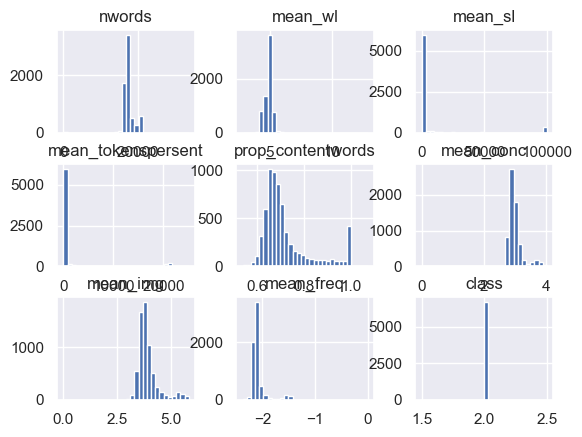

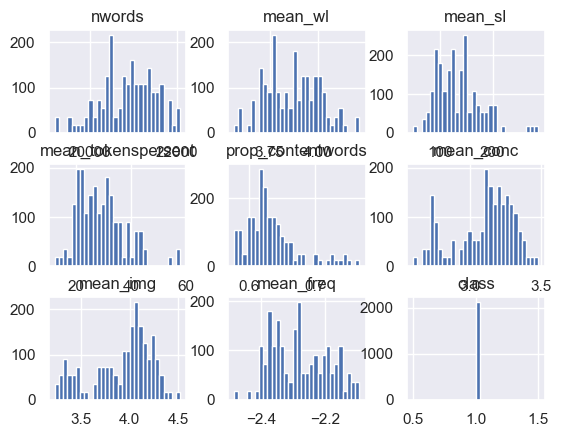

In [29]:
legal_df.hist(bins=30)
creative_df.hist(bins=30);

In [8]:
wp_path = ds_writingprompts()
writingprompts = read_texts(wp_path["train"][1], length=input_length)
writingprompts.extend(read_texts(wp_path["test"][1], length=input_length))
writingprompts.extend(read_texts(wp_path["val"][1], length=input_length))

# Length (100_000 chars) = 100089
print(f"Length of writingprompts dataset: {len(writingprompts)}")

wp_results = process_texts(list((_, f"writingprompts_{i}") for i,_ in enumerate(writingprompts)))
writingprompts_df = pd.DataFrame(wp_results)
writingprompts_df.insert(writingprompts_df.shape[1], "class", 2)
writingprompts_df.head()

 50%|█████     | 5056/10089 [10:00<00:49, 101.86it/s] 

After running the pipeline, we concatenate the results into a single dataframe which we can then use for further analysis. 

In [14]:
# Join
df = pd.concat([creative_df, legal_df], ignore_index=True)
df = df.join(pd.json_normalize(df["prop_pos"]).fillna(0.0)) # type: ignore



## Experiment


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xdf = df.drop(["title", "class", "prop_pos"],axis=1)
ydf = df["class"]
xtrain, xtest, ytrain, ytest = train_test_split(xdf, ydf,test_size=0.1)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1)

reg = LogisticRegression()
reg.fit(xtrain, ytrain)
predicts = reg.predict(xtest)

accuracy_score(predicts, ytest)

0.8

,0
nwords,-0.004579
mean_wl,0.117580
mean_sl,0.627675
mean_tokenspersent,-0.396088
prop_contentwords,0.008830
mean_conc,0.033159
mean_img,0.048549
NOUN,0.009852
VERB,0.000534
ADJ,0.002282


<BarContainer object of 10 artists>

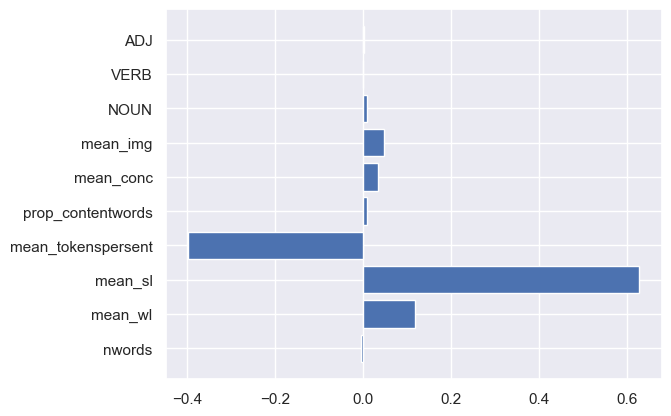

In [16]:
display_df = pd.DataFrame(reg.coef_.T, index=xdf.columns)
display(display_df)

import matplotlib.pyplot as plt

plt.barh(display_df.index,display_df[0])

- Write about lemmatization approaches
- Possibly make a diagram for how the process goes